# In class exercises for 11.02.2020 (Filtering)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need: numpy, matplotlib.pyplot, my_brick_filt 
import numpy as np
import matplotlib.pyplot as plt
import my_brick_filt

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


## Like last week: extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [3]:
data2000 = data[:,(tx>=0) & (tx<2000)]
ind2000 = np.where((tx>=0) & (tx<2000))


## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

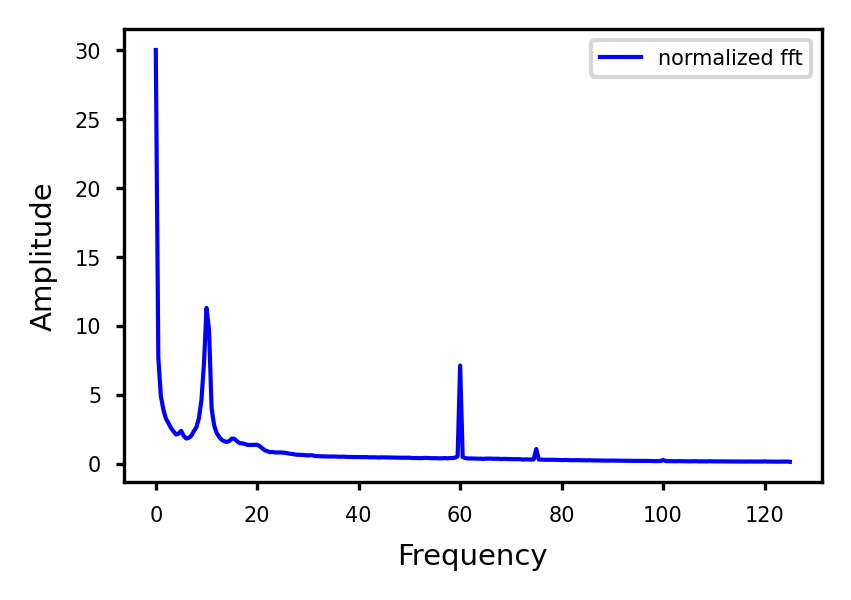

In [4]:
plt.style.use('felix')
r,c = data2000.shape

# fft each trial
sp = np.fft.rfft(data2000, axis=1)
amp = np.abs(sp)
amp_norm = (amp / c) *2

amp_mean = np.mean(amp_norm, axis=0)
# get freq axis
freq = np.fft.rfftfreq(c, 1/sr)   # Sample spacing is 2nd arg
plt.plot(freq, amp_mean, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial
* bonus if you finish the other stuff: make the apply_filt function matrisized! pay attention to the dimension of the data you are passing into the fft function - you want to fft across time! I wrote one and included it in my "my_brick_filter" .py file if you want to see one way to do it or to check your work...

In [5]:
filter20hz = my_brick_filt.define_filt(freq, 20, 'lp')

data2000_filt = my_brick_filt.apply_filt_2D(input_sig=data2000, input_filter=filter20hz)
filter20hz.shape

(251,)

## Then FFT it again to see if you got rid of the hf components of the signal

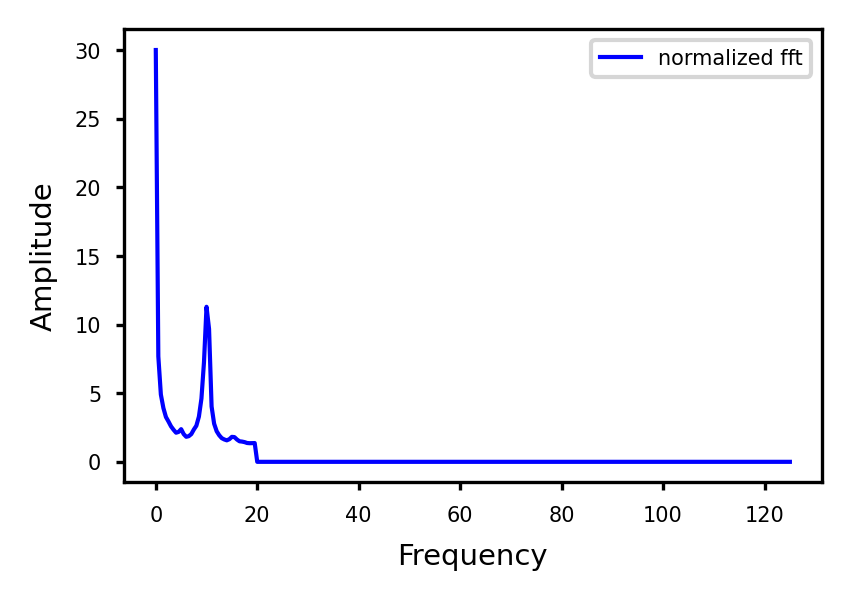

In [6]:
sp = np.fft.rfft(data2000_filt, axis=1)
amp = np.abs(sp)
amp_norm = (amp / c) *2

amp_mean = np.mean(amp_norm, axis=0)
plt.plot(freq, amp_mean, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter, then make a hp filter
* Then combine the two filters so that the frequencies you want are marked with a "1" in the filter and those that you don't want are marked with a "0" in the filter. 
* Then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

In [7]:
def define_bp_filt(fx, hp_freq, lp_freq, bp_type='pass'):

    """Define a simple band pass filter brick wall filter - don't use this in practice, just for tutorial

    Args:
        fx (array): list of frequencies, taken from np.fft.rfftfreq
        lp_freq (float): cutoff frequency for lowpass filter
        hp_freq (float): cutoff frequency for highpass filter

    Returns:
        brick: brick wall filter in frequency domain

    """
    
    
    # find the freq in our FFT range that is closest to our desired cutoff point
    cutoff_pnt_lp = np.argmin(np.abs(fx-lp_freq))
    cutoff_pnt_hp = np.argmin(np.abs(fx-hp_freq))

    # init filter with all 0's
    lp = np.zeros(len(fx))
    hp = np.zeros(len(fx))
    
    if bp_type == 'stop':
        lp=np.ones(len(fx))
        lp[cutoff_pnt_hp:cutoff_pnt_lp] = 0
        return lp
    elif bp_type=='pass':
        lp[0:cutoff_pnt_lp] = 1
        hp[cutoff_pnt_hp:] = 1
    return lp * hp


bp_filt2000 = define_bp_filt(freq, 6, 14,'pass')
data2000_bp_filt = my_brick_filt.apply_filt_2D(input_sig=data2000, input_filter=bp_filt2000)

## Then FFT and look at filtered signal in the time and frequency domains (time domain on one plot, and freq on the other)

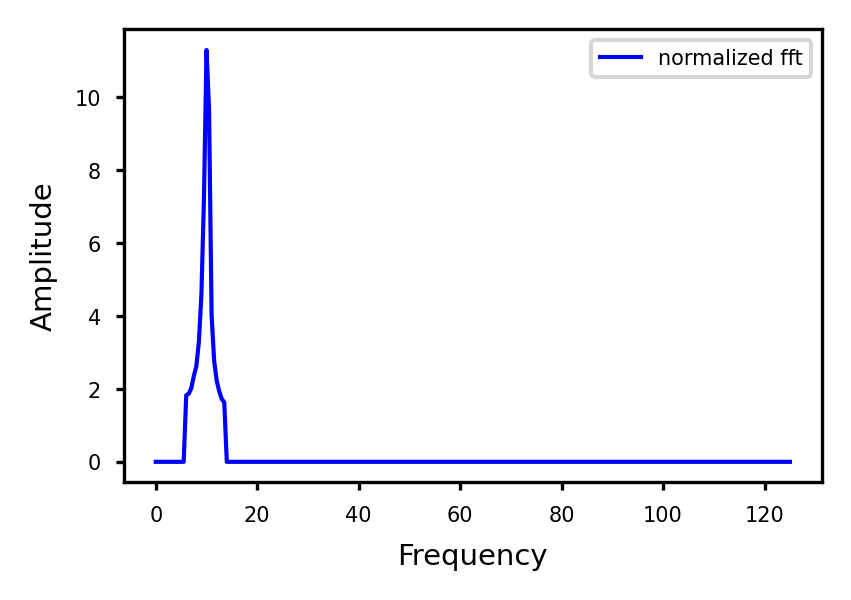

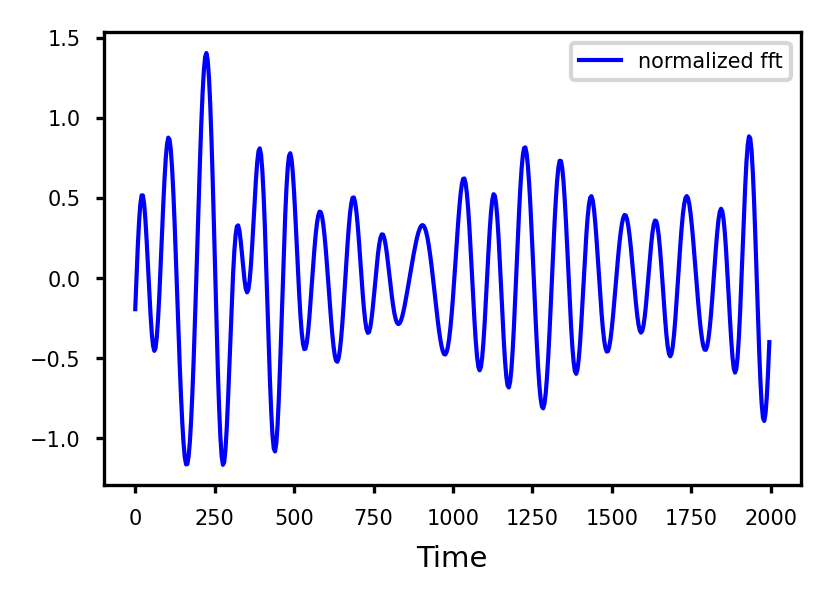

In [8]:
sp = np.fft.rfft(data2000_bp_filt, axis=1)
amp = np.abs(sp)
amp_norm = (amp / c) *2

amp_mean = np.mean(amp_norm, axis=0)
plt.plot(freq, amp_mean, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

plt.plot(tx[ind2000], np.mean(data2000_bp_filt,axis=0), 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Time')
plt.show()

## You can also make a band-stop filter using a similar logic
* A band stop filter will reduce the amplitude of a specific range of frequencies - often used for removing an artifact like line noise (60Hz AC noise) from physiological recordings!
* Think for a minute, or maybe sketch out, what this kind of a filter should look like
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

In [11]:

bp_filt2000 = define_bp_filt(freq, 50, 70, 'stop')
data2000_bp_filt = my_brick_filt.apply_filt_2D(input_sig=data2000, input_filter=bp_filt2000)

## Then FFT and look at filtered signal in the frequency domain

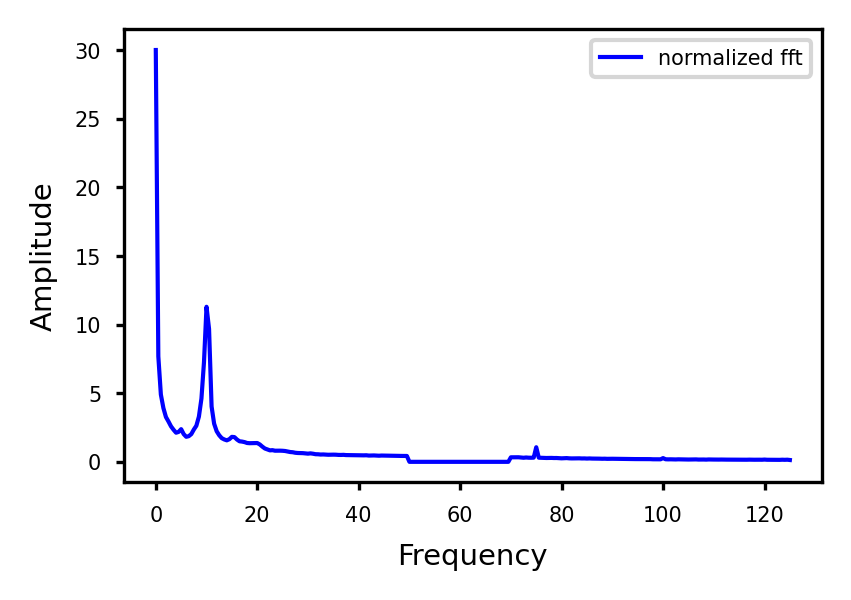

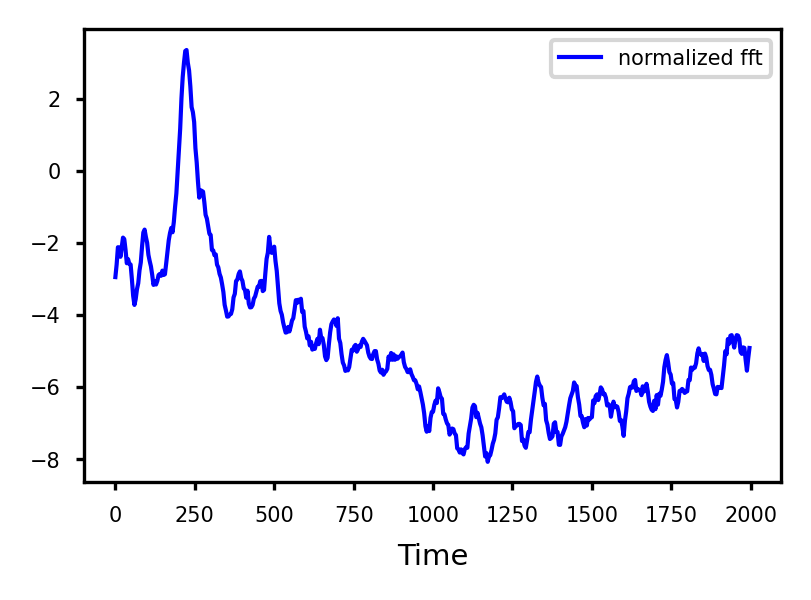

In [12]:
sp = np.fft.rfft(data2000_bp_filt, axis=1)
amp = np.abs(sp)
amp_norm = (amp / c) *2

amp_mean = np.mean(amp_norm, axis=0)
plt.plot(freq, amp_mean, 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

plt.plot(tx[ind2000], np.mean(data2000_bp_filt,axis=0), 'b', linewidth=1)          # plot amplitude (power = np.absolute(sp)**2)
plt.legend(['normalized fft'], loc='best', fancybox=1)  
plt.xlabel('Time')
plt.show()

# BONUS: Read the end of the tutorial and figure out to do this all more gracefully using blackman windowed filters :) 